In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import sys
from LongTable import *

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

In [2]:
# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])


In [3]:
del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

In [4]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
YRI_samples = [x for x in YRI_samples if ((x != 'NA18855') and (x[:2]=='NA'))]

RPKM_median = RPKM[YRI_samples].median(axis=1)

rpkm_1, rpkm_2, rpkm_3, rpkm_4 = get_series_quantile(RPKM_median)


lt1 = long_table.loc[long_table.gene.isin(rpkm_1)]
df_rpkm1, order = longtable_to_boxplot(lt1)

lt2 = long_table.loc[long_table.gene.isin(rpkm_2)]
df_rpkm2, order = longtable_to_boxplot(lt2)

lt3 = long_table.loc[long_table.gene.isin(rpkm_3)]
df_rpkm3, order = longtable_to_boxplot(lt3)

lt4 = long_table.loc[long_table.gene.isin(rpkm_4)]
df_rpkm4, order = longtable_to_boxplot(lt4)

rpkm_df = pd.DataFrame()
unprod_juncs = list(df_rpkm1.loc[df_rpkm1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm2.loc[df_rpkm2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm3.loc[df_rpkm3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm4.loc[df_rpkm4.assay=='chRNA'].Unproductive_juncs)

rpkm_df['unprod_juncs'] = unprod_juncs
rpkm_df['rpkm_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [5]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

In [6]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

NMD_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

pc_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(pc_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

genes_index = NMD_counts.index.intersection(pc_counts.index)

chRNA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

ml30_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/MetabolicLabelled.30min/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]


In [7]:
polyA_log2RPKM = polyA_RPKM[polyA_RPKM.columns[5:]].median(axis=1)
ml30_log2RPKM = ml30_RPKM[ml30_RPKM.columns[5:]].median(axis=1)
chRNA_log2RPKM = chRNA_RPKM[chRNA_RPKM.columns[5:]].median(axis=1)


polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
ml30_log2RPKM.index = [x.split('.')[0] for x in ml30_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
NMD_counts.index = [x.split('.')[0] for x in NMD_counts.index]
pc_counts.index = [x.split('.')[0] for x in pc_counts.index]


chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(polyA_genes).intersection(NMD_counts.index).intersection(pc_counts.index)


total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts

chRNA_juncs_NMD_ratio = np.log2(NMD_percent.loc[genes_index].mean(axis=1))




NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
chRNA_polyA_log2_difference = chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]
ml30_polyA_log2_difference = ml30_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]

In [8]:
chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(genes_index).intersection(polyA_genes)

In [9]:
total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts


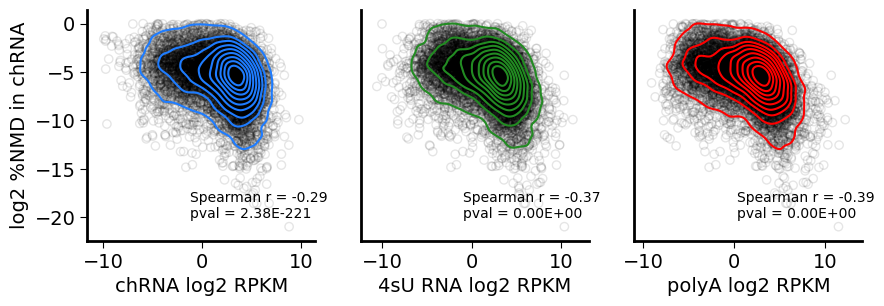

In [10]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax[0], xy=(0.45, 0.1), **kwargs)

plot_correlation(ml30_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='forestgreen', #title='chRNA',
                 xlabel='4sU RNA log2 RPKM', ax=ax[1], xy=(0.45, 0.1), **kwargs)

plot_correlation(polyA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='red', #title='chRNA',
                 xlabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log2 %NMD in chRNA', size=14)

ax[1].set_yticks([])
ax[2].set_yticks([])

# plt.show()

plt.savefig(figdir + 'supplementary_note/Fig1.Supp_RPKM_v_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_note/Fig1.Supp_RPKM_v_NMD.png', dpi=300, bbox_inches='tight',)

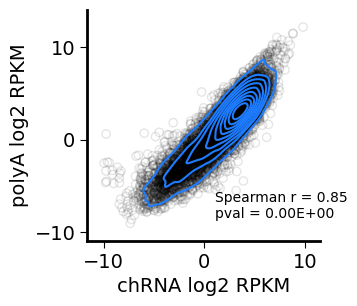

In [11]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('polyA log2 RPKM', size=14)

plt.savefig(figdir + 'supplementary_note/chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

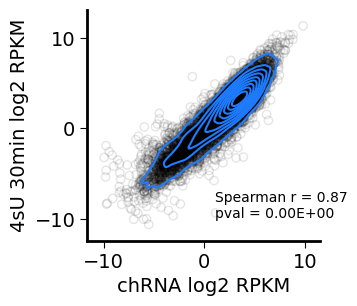

In [12]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], ml30_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', ylabel='ml30 log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('4sU 30min log2 RPKM', size=14)

plt.savefig(figdir + 'supplementary_note/chRNA_4sU_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/chRNA_4sU_expression.pdf', bbox_inches='tight', dpi=300)

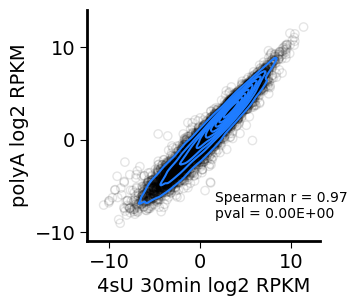

In [13]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(ml30_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', xlabel='ml30 log2 RPKM', #title='chRNA',
                 ylabel='polyA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('4sU 30min log2 RPKM', size=14)
ax.set_ylabel('polyA log2 RPKM', size=14)

plt.savefig(figdir + 'supplementary_note/4sU_polyA_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/4sU_polyA_expression.pdf', bbox_inches='tight', dpi=300)

In [14]:
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]


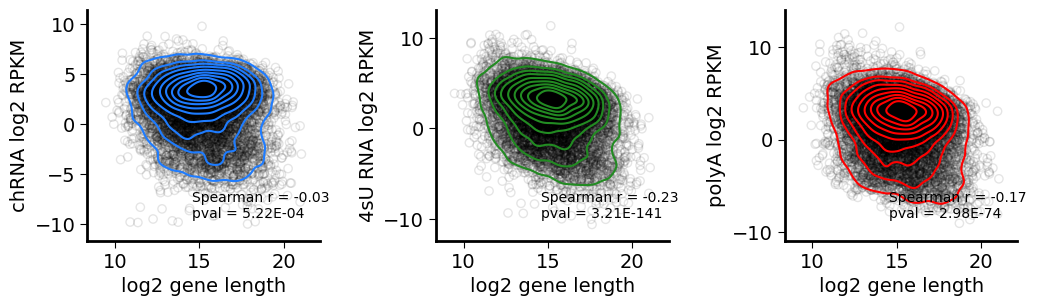

In [15]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.5}, figsize=(12, 3))

plot_correlation(np.log2(gene_len.loc[genes_index]), chRNA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', xlabel='log2 gene length', #title='chRNA',
                 ylabel='chRNA log2 RPKM', ax=ax[0], xy=(0.45, 0.1), **kwargs)

plot_correlation(np.log2(gene_len.loc[genes_index]), ml30_log2RPKM.loc[genes_index], #np.log2(NMD_percent.mean(axis=1)),
                 contour_color='forestgreen', xlabel='log2 gene length', #title='chRNA',
                 ylabel='4sU RNA log2 RPKM', ax=ax[1], xy=(0.45, 0.1), **kwargs)

plot_correlation(np.log2(gene_len.loc[genes_index]), polyA_log2RPKM.loc[genes_index], #np.log2(NMD_percent.mean(axis=1)),
                 contour_color='red', xlabel='log2 gene length',#title='chRNA',
                 ylabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
# ax[0].set_xlabel('log2 RPKM', size=14)
# ax[0].set_ylabel('log2 gene length', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.savefig(figdir + 'supplementary_note/length_v_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/length_v_expression.pdf', bbox_inches='tight', dpi=300)

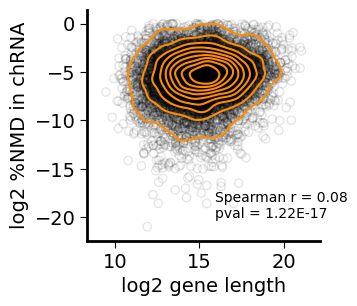

In [29]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(np.log2(gene_len.loc[genes_index]), np.log2(NMD_percent.mean(axis=1)),
                 contour_color='darkorange', xlabel='log2FC chRNA vs polyA', #title='chRNA',
                 ylabel='log2 %NMD', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('log2 gene length', size=14)
ax.set_ylabel('log2 %NMD in chRNA', size=14)

plt.savefig(figdir + 'supplementary_note/length_v_NMD.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/length_v_NMD.pdf', bbox_inches='tight', dpi=300)

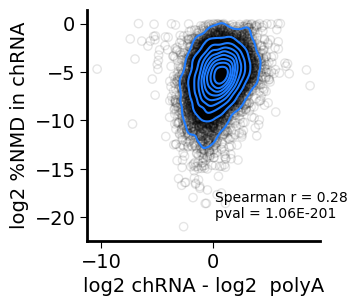

In [28]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='#1e7cff', xlabel='log2FC chRNA vs polyA', #title='chRNA',
                 ylabel='log2 %NMD', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('log2 chRNA - log2  polyA', size=14)
ax.set_ylabel('log2 %NMD in chRNA', size=14)

plt.savefig(figdir + 'supplementary_note/log2FC_v_NMD.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/log2FC_v_NMD.pdf', bbox_inches='tight', dpi=300)

In [17]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)


In [18]:
logFC = []
quartile = []
df = pd.DataFrame()
for i in range(5):
    logFC += list(chRNA_log2RPKM.loc[NMD_ratio_quant_all_genes[i]] - polyA_log2RPKM.loc[NMD_ratio_quant_all_genes[i]])
    quartile += ['Q' + str(i+1)]*len(NMD_ratio_quant_all_genes[i])
    
df['logFC'] = logFC
df['quartile'] = quartile

Text(0, 0.5, 'log2FC chRNA vs polyA')

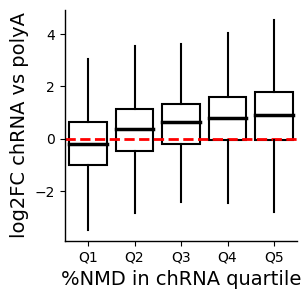

In [19]:
# sns.boxplot(data=df, x = 'quartile', y='logFC')

# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(figsize=(3, 3))


sns.boxplot(data=df, x='quartile', y='logFC', width=0.8, ax=ax, zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

plt.plot([-0.5, 4.5], [0, 0], 'r--', linewidth=2)
    
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticks([])
# ax.set_yticks([])
ax.patch.set_facecolor('none')
ax.set_xlabel('%NMD in chRNA quartile', size=14)
ax.set_ylabel('log2FC chRNA vs polyA', size=14)

# plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.png', dpi=300, bbox_inches='tight',)

In [20]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_logRPKM = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_logRPKM[h3k36me3_logRPKM.columns[5:]]
h3k36me3_logRPKM.index = [x.split('.')[0] for x in h3k36me3_logRPKM.index]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_index]
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM.median(axis=1) - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene

H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = [x for x in H3K4ME3.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM[H3K4ME3_samples]
h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_CPM.index = [x.split('.')[0] for x in h3k4me3_CPM.index]

h3k4me3_idx = genes_index.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k4me3_idx]




H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = [x for x in H3K27AC.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM[H3K27AC_samples]

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_CPM.index = [x.split('.')[0] for x in h3k27ac_CPM.index]

h3k27ac_idx = genes_index.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k27ac_idx]



In [21]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)
polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
chRNA_juncs_NMD_ratio.index = [x.split('.')[0] for x in chRNA_juncs_NMD_ratio.index]

ensembl_idx = chRNA_juncs_NMD_ratio.index.intersection(scores.index).intersection(chRNA_log2RPKM.index)
df_scores = scores.loc[ensembl_idx]
df_scores['NMD'] = np.array(chRNA_juncs_NMD_ratio.loc[ensembl_idx])
df_scores['RPKM'] = np.array(chRNA_log2RPKM.loc[ensembl_idx])
df_scores['logFC'] = np.array(chRNA_log2RPKM.loc[ensembl_idx] - polyA_log2RPKM.loc[ensembl_idx])


In [22]:
polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
genes_idx= polyA_log2RPKM.index.intersection(chRNA_log2RPKM.index).intersection(chRNA_juncs_NMD_ratio.index).intersection(
ml30_log2RPKM.index).intersection(h3k36me3_log2RPKM.index).intersection(gene_len.index).intersection(
    h3k4me3_log2RPKM.index).intersection(h3k27ac_log2RPKM.index).intersection(df_scores.index)

In [23]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx])
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx])
df['NMD'] = zscore(chRNA_juncs_NMD_ratio.loc[genes_idx])
df['4sU'] = zscore(ml30_log2RPKM.loc[genes_idx])
df['H3K27AC'] = zscore(h3k27ac_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))
df['log2_s_score'] = zscore(np.log2(df_scores.post_mean))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length', 'log2_s_score'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.7455631223104837, 'NMD': 0.021507778487716393, 'gene_length': 0.027804610372846546, 'log2_s_score': 0.005429076531899463}


In [39]:
df_resid = pd.DataFrame(np.zeros([3, 3]))
df_resid.columns = ['histones', 'chRNA', '4sU']
df_resid.index = ['chRNA', '4sU', 'polyA']

df_coef = pd.DataFrame(np.zeros([3, 3]))
df_coef.columns = ['histones', 'chRNA', '4sU']
df_coef.index = ['chRNA', '4sU', 'polyA']

for assay in ['chRNA', '4sU', 'polyA']:
    model, r2 = run_regression(df, ['H3K27AC', 'H3K4ME3','H3K36ME3', 'gene_length', #'log2_s_score'
                                   ], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, 'histones'] = var['NMD']
    df_coef.loc[assay, 'histones'] = model2.params.loc['NMD']
    
for assay in ['4sU', 'polyA']:
    model, r2 = run_regression(df, ['chRNA', 'gene_length', #'log2_s_score'
                                   ], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, 'chRNA'] = var['NMD']
    df_coef.loc[assay, 'chRNA'] = model2.params.loc['NMD']

for assay in ['polyA']:
    model, r2 = run_regression(df, ['4sU', 'gene_length', #'log2_s_score'
                                   ], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, '4sU'] = var['NMD']
    df_coef.loc[assay, '4sU'] = model2.params.loc['NMD']
    
df_resid = df_resid * 100

chRNA
{'NMD': 0.02300156534260378}
4sU
{'NMD': 0.0716121285312874}
polyA
{'NMD': 0.09500489192090156}
4sU
{'NMD': 0.06618581555625436}
polyA
{'NMD': 0.08657560010612586}
polyA
{'NMD': 0.023407277772045876}


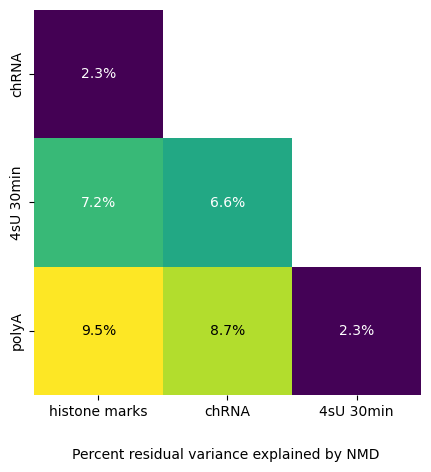

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.heatmap(df_resid, mask=np.array(([[0, 1, 1], [0, 0, 1], [0, 0, 0]])), cmap='viridis', cbar=False, ax=ax)
g.set_yticks([0.5, 1.5, 2.5], ['chRNA', '4sU 30min', 'polyA'])
g.set_xticks([0.5, 1.5, 2.5], ['histone marks', 'chRNA', '4sU 30min'])
g.text(0.5, 0.5, "{:.1f}%".format(df_resid.loc['chRNA', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 1.5, "{:.1f}%".format(df_resid.loc['4sU', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 2.5, "{:.1f}%".format(df_resid.loc['polyA', 'histones']), ha="center", va="center", color="black")
g.text(1.5, 1.5, "{:.1f}%".format(df_resid.loc['4sU', 'chRNA']), ha="center", va="center", color="w")
g.text(1.5, 2.5, "{:.1f}%".format(df_resid.loc['polyA', 'chRNA']), ha="center", va="center", color="black")
g.text(2.5, 2.5, "{:.1f}%".format(df_resid.loc['polyA', '4sU']), ha="center", va="center", color="w")
ax.text(0.3, 3.5, 'Percent residual variance explained by NMD')
# g.set_title_coords(-0.15,-0.1)
# plt.savefig(figdir + 'supplementary_figures/regression_variance_explained_NMD.pdf', dpi=300, bbox_inches='tight')

plt.savefig(figdir + 'supplementary_note/regression_variance_explained_NMD.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/regression_variance_explained_NMD.pdf', bbox_inches='tight', dpi=300)

In [41]:
df_coef

,histones,chRNA,4sU
chRNA,-0.151663,0.000000,0.000000
4sU,-0.267604,-0.257266,0.000000
polyA,-0.308229,-0.294237,-0.152994


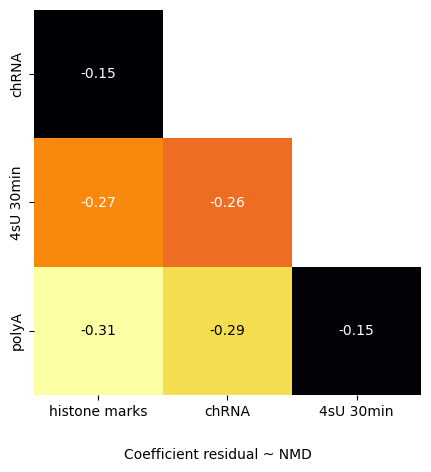

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.heatmap(df_coef, mask=np.array(([[0, 1, 1], [0, 0, 1], [0, 0, 0]])), cmap='inferno_r', cbar=False, ax=ax)
g.set_yticks([0.5, 1.5, 2.5], ['chRNA', '4sU 30min', 'polyA'])
g.set_xticks([0.5, 1.5, 2.5], ['histone marks', 'chRNA', '4sU 30min'])
g.text(0.5, 0.5, "{:.2f}".format(df_coef.loc['chRNA', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 1.5, "{:.2f}".format(df_coef.loc['4sU', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 2.5, "{:.2f}".format(df_coef.loc['polyA', 'histones']), ha="center", va="center", color="black")
g.text(1.5, 1.5, "{:.2f}".format(df_coef.loc['4sU', 'chRNA']), ha="center", va="center", color="w")
g.text(1.5, 2.5, "{:.2f}".format(df_coef.loc['polyA', 'chRNA']), ha="center", va="center", color="black")
g.text(2.5, 2.5, "{:.2f}".format(df_coef.loc['polyA', '4sU']), ha="center", va="center", color="w")
ax.text(0.7, 3.5, 'Coefficient residual ~ NMD')
# g.set_title_coords(-0.15,-0.1)
plt.savefig(figdir + 'supplementary_note/regression_slope_NMD.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'supplementary_note/regression_slope_NMD.pdf', bbox_inches='tight', dpi=300)